In [53]:
import pandas as pd
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last" #"last expr -> all로 바꾸면 전체가 나온다. "
pd.options.display.max_columns = 200
pd.options.display.max_rows = 250
pd.options.display.max_colwidth = 100

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
import pickle 
from util import accuracy
from training_util_mae2 import (MyDataset, split, Transformer_park, Transformer_pretrain,
                        base_model, base_decoder, hierachy_model, train, validate, weighted_sampling,
                              eval_model)
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm 

import torch
import os
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (confusion_matrix, accuracy_score, classification_report, auc, roc_auc_score,
                             precision_recall_curve, roc_curve, average_precision_score)
from sklearn.preprocessing import label_binarize
import easydict


<ipython-input-53-28835eb56e5c>:16: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


In [54]:
def loading_model(args, loaded_model):
    b_model = base_model(n_each_base = args.n_each_base,
                         mask_on=args.mask_on)
    vital_model = Transformer_park(n_each_lab = args.n_each_vital,
                                       n_embed = args.n_embed, 
                                       nhead = args.nhead, 
                                       nhid = args.nhid, 
                                       nlayers = args.nlayers, 
                                       dropout = args.dropout, 
                                       mask_on = args.mask_on)
    lab_model = Transformer_park(n_each_lab = args.n_each_lab,
                                     n_embed = args.n_embed, 
                                     nhead = args.nhead, 
                                     nhid = args.nhid, 
                                     nlayers = args.nlayers, 
                                     dropout = args.dropout, 
                                     mask_on = args.mask_on )
    decoder_vital = Transformer_pretrain(n_each_lab = args.n_each_vital,
                                        n_embed = args.n_embed)
    decoder_lab = Transformer_pretrain(n_each_lab = args.n_each_lab,
                                       n_embed = args.n_embed)
    decoder_base = base_decoder(n_each_base = args.n_each_base)
    total_model = hierachy_model(vital_shape = args.vital_shape, 
                                 lab_shape = args.lab_shape, 
                                 batch_size =args.test_batchsize, 
                                 output_len = args.output_len)

    vital_model.load_state_dict(loaded_model['vital_model_dict'])
    lab_model.load_state_dict(loaded_model['lab_model_dict'])
    b_model.load_state_dict(loaded_model['b_model_dict'])
    total_model.load_state_dict(loaded_model['total_model_dict'])
    decoder_vital.load_state_dict(loaded_model['decoder_vital_dict'])
    decoder_lab.load_state_dict(loaded_model['decoder_lab_dict'])
    decoder_base.load_state_dict(loaded_model['decoder_base_dict'])
    
    vital_model.eval()
    lab_model.eval()
    b_model.eval()
    total_model.eval()
    decoder_vital.eval()
    decoder_lab.eval()
    decoder_base.eval()

    return vital_model, lab_model, b_model, total_model, decoder_vital, decoder_lab, decoder_base

In [55]:
def predicted_outcome(test_loader, vital_model, lab_model, b_model, total_model, 
                decoder_vital, decoder_lab, decoder_base):
    for batch, batch_data in enumerate(test_loader):
        vital_set = batch_data[0]
        lab_set = batch_data[1]
        baseline_set = batch_data[2]
        each_att_vital_set = batch_data[3]
        each_att_lab_set = batch_data[4]
        each_att_base_set = batch_data[5]
        att_vital_set = batch_data[6]
        att_lab_set = batch_data[7]
        outcome = batch_data[8]
        outcome = outcome.type(torch.LongTensor)

        vital_tensor = vital_model(vital_set.transpose(0,1), att_vital_set,
                                   each_mask = each_att_vital_set.transpose(0,1))
        lab_tensor = lab_model(lab_set.transpose(0,1), att_lab_set,
                               each_mask = each_att_lab_set.transpose(0,1))
        base_tensor = b_model(baseline_set, each_att_base_set)

        vital_out = decoder_vital(vital_tensor)  #MLM용도
        lab_out = decoder_lab(lab_tensor)    #MLM 용도
        base_out = decoder_base(base_tensor) #MLM 용도

        #compute loss
        result = total_model(vital_tensor, lab_tensor, base_tensor)
        
        if batch==0:
            result_t = result.cpu().detach()
            outcome_t =outcome.cpu().detach()
        else:
            result_t = torch.cat([result.cpu(), result_t],axis=0).detach()
            outcome_t = torch.cat([outcome.cpu(), outcome_t],axis=0).detach()
            
    return result_t, outcome_t

In [56]:
def auroc_auprc(predicted, outcome):
    val_acc1, val_acc2 = accuracy(predicted, outcome, topk=(1,2))
    soft = nn.Softmax(dim=1)
    s_predicted = soft(predicted).detach().numpy()
    outcome_onehot = label_binarize(outcome, classes=[0,1,2])

    avscore = average_precision_score(outcome_onehot, s_predicted, average='weighted')
    val_acc1 = val_acc1.item()
    roc_weight_val = roc_auc_score(outcome_onehot, s_predicted, 
                                   multi_class= 'ovr', average = 'weighted')

    return val_acc1, roc_weight_val, avscore

In [57]:
args = easydict.EasyDict({"masking_value": 0, #masking value selection 
                          "batch_size": 1000, #number of each batch 
                          "file_name": "../whole_3data0630_o2_idscale.txt",
                          "min_epoch": 200, #minimum epoch for training
                          "n_epochs_stop": 10, #stop epoch after nth training without performance gain
                          "epochs": 1000, #maximum epoch 
                          "early_stop": True, #setting of early stopping
                          "nhead": 4,  #transformer number of head
                          "n_embed": 160, #transformer number of embedding layer
                          "nhid": 320, #transformer number of hidden layer
                          "nlayers": 4, #transformenr encoder layer number
                          "dropout": 0.2, #drop out 
                          "lr_": 5e-5, #learning rate
                          "weight_decay_": 1e-4, #weight decay
                          "output_len": 3, #number of output category number
                          "prior_d":0, #prediction day 0 or day 1 or day 2
                          "weight": 1.0, #weight of decoder loss
                          "mae": False, #use of masked autoencoder 
                          "mask_on":True, #use of masking layer
                          "masking_ratio": 0., #MAE ratio when it used
                          "metric": 'total_loss', #early stopping reference 
                          "cuda_i" : 1, #cuda device number
                            "save_path" : "./save_confidence_interval" #save folder name 
                          })

### select model with input length of 18 days
* the number means random seed of splitting

In [64]:
number=2; padded_hosday = 18

train_set, valid_set, test_set = split(args.file_name, random_s=number) 

args.n_each_vital = train_set[0][2].shape[-1]
args.n_each_lab = train_set[0][1].shape[-1]
args.n_each_base = train_set[0][0].shape[-1]

args.vital_shape = padded_hosday*3*args.n_embed
args.lab_shape = padded_hosday*args.n_embed

def get_filepath(path):
    filename = [x for x in os.listdir(path) if "hos18" in x and "model2" in x]
    if len(filename)==1:
        filepath = path+filename[0]
    return filepath

filepath0 = get_filepath("./save_confidence_interval/")
filepath1 = get_filepath("./save_confidence_interval_day1/")
filepath2 = get_filepath("./save_confidence_interval_day2/")

### get the each prediction result 

In [65]:
first = pd.DataFrame()
day1 = pd.DataFrame()
day2 = pd.DataFrame()

# for i in range(20):
for i in tqdm(range(len(test_set))):
    list_except = []
    # if test_set[i:1+i][0][1].shape[0]>2:
    try:
        loaded_model_0 = torch.load(filepath0)
        test_dataset = MyDataset(args.masking_value, test_set[i:1+i], 
                                 padded_hosday, data_pr = 1, prior_d=args.prior_d)
        test_loader = DataLoader(test_dataset, batch_size=len(test_dataset),
                                     shuffle=False, drop_last=True)
        args.test_batchsize = len(test_dataset)
        load_0 = loading_model(args, loaded_model_0)
        predicted, outcome = predicted_outcome(test_loader, load_0[0], load_0[1],
                                       load_0[2],load_0[3], load_0[4], load_0[5], load_0[6])
        predicted = pd.DataFrame(predicted)
        predicted['outcome']=outcome
        predicted['patient'] = i
        predicted_ = predicted.reset_index()
        first = pd.concat([first, predicted_], axis=0)

        loaded_model_1 = torch.load(filepath1)
        test_dataset1 = MyDataset(args.masking_value, test_set[i:1+i], 
                                 padded_hosday, data_pr = 1, prior_d=1)
        test_loader1 = DataLoader(test_dataset1, batch_size=len(test_dataset1),
                                     shuffle=False, drop_last=True)
        args.test_batchsize = len(test_dataset1)
        load_1 = loading_model(args, loaded_model_1)
        predicted1, outcome1 = predicted_outcome(test_loader1, load_1[0], load_1[1],
                                       load_1[2],load_1[3], load_1[4], load_1[5], load_1[6])
        predicted1 = pd.DataFrame(predicted1)
        predicted1['outcome']=outcome1
        predicted1['patient'] = i

        predicted1_ = predicted1.reset_index()
        day1 = pd.concat([day1, predicted1_], axis=0)
        # accura1_d1, auroc_test_d1, auprc_test_d1 = auroc_auprc(predicted1, outcome1)
        loaded_model_2 = torch.load(filepath2)
        test_dataset2 = MyDataset(args.masking_value, test_set[i:1+i], 
                                 padded_hosday, data_pr = 1, prior_d=2)

        test_loader2 = DataLoader(test_dataset2, batch_size=len(test_dataset2),
                                     shuffle=False, drop_last=True)
        args.test_batchsize = len(test_dataset2)
        load_2 = loading_model(args, loaded_model_2)
        predicted2, outcome2 = predicted_outcome(test_loader2, load_2[0], load_2[1],
                                       load_2[2],load_2[3], load_2[4], load_2[5], load_2[6])
        predicted2 = pd.DataFrame(predicted2)
        predicted2['outcome']=outcome2
        predicted2['patient'] = i

        predicted2_ = predicted2.reset_index()
        day2 = pd.concat([day2, predicted2_], axis=0)

    except:
        list_except.append(i)

100%|██████████| 801/801 [05:14<00:00,  2.55it/s]


### the first means day 0 prediction 
* index means the date of hospital day 
* patients means the 

In [66]:
first

,index,0,1,2,outcome,patient
0,0,5.275229,1.000527,-7.077427,0,0
1,1,5.860030,0.961213,-7.586836,0,0
2,2,6.556362,0.801813,-8.261553,0,0
3,3,7.315451,0.612047,-8.893461,0,0
4,4,8.792710,-0.190936,-9.657278,0,0
...,...,...,...,...,...,...
13,13,-6.695903,-1.741546,5.607242,2,800
14,14,-6.602851,-1.676353,5.494049,2,800
15,15,-6.361062,-1.508437,5.097911,2,800
16,16,-5.352225,-0.889878,3.953225,2,800


In [67]:
first.head()

,index,0,1,2,outcome,patient
0,0,5.275229,1.000527,-7.077427,0,0
1,1,5.860030,0.961213,-7.586836,0,0
2,2,6.556362,0.801813,-8.261553,0,0
3,3,7.315451,0.612047,-8.893461,0,0
4,4,8.792710,-0.190936,-9.657278,0,0


In [61]:
daily_auroc.head(), daily_auroc_d1.head()

(  index   accuracy     auroc     auprc
 0     0  94.618271  0.977715  0.975293
 0     1  96.370468  0.994328  0.989514
 0     2  96.231155  0.992511  0.986133
 0     3  94.663284   0.98895  0.980893
 0     4  93.359375   0.98708  0.973114,
   index   accuracy     auroc     auprc
 0     1   89.82412   0.92151  0.931646
 0     2   92.21106  0.974525  0.971983
 0     3  92.249054  0.976996  0.965359
 0     4  91.276039  0.975587  0.962925
 0     5  88.472229  0.965852  0.944471)

In [14]:
daily_auroc = pd.DataFrame(columns = ['index','accuracy','auroc','auprc'])
for i in range(20):
    try:
        predicted = torch.tensor(first.loc[first['index']==i,[0,1,2]].values)
        outcome = torch.tensor(first.loc[first['index']==i,'outcome'].values)
        data = pd.DataFrame({(i,*auroc_auprc(predicted,outcome))},
                           columns = ['index','accuracy','auroc','auprc'])
        daily_auroc = pd.concat([daily_auroc, data], axis=0)
    except(ValueError):
        print(i)

daily_auroc_d1 = pd.DataFrame(columns = ['index','accuracy','auroc','auprc'])
for i in range(20):
    try:
        predicted = torch.tensor(day1.loc[day1['index']==i,[0,1,2]].values)
        outcome = torch.tensor(day1.loc[day1['index']==i,'outcome'].values)
        data = pd.DataFrame({(i,*auroc_auprc(predicted,outcome))},
                           columns = ['index','accuracy','auroc','auprc'])
        daily_auroc_d1 = pd.concat([daily_auroc_d1, data], axis=0)
    except(ValueError):
        print(i)
daily_auroc_d1['index']+=1

daily_auroc_d2 = pd.DataFrame(columns = ['index','accuracy','auroc','auprc'])
for i in range(20):
    try:
        predicted = torch.tensor(day2.loc[day2['index']==i,[0,1,2]].values)
        outcome = torch.tensor(day2.loc[day2['index']==i,'outcome'].values)
        data = pd.DataFrame({(i,*auroc_auprc(predicted,outcome))},
                           columns = ['index','accuracy','auroc','auprc'])
        daily_auroc_d2 = pd.concat([daily_auroc_d2, data], axis=0)
    except(ValueError):
        print(i)
daily_auroc_d2['index']+=2

daily_total = pd.merge(daily_auroc, daily_auroc_d1, on='index', how='outer')
daily_total = pd.merge(daily_total, daily_auroc_d2, on='index', how='outer')
daily_total['count']= first.groupby(['index'])['outcome'].count()[:22]
daily_total = daily_total[:20]

/home/ubuntu/anaconda3/envs/park/lib/python3.8/site-packages/pandas/core/reshape/merge.py:916: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  key_col = Index(lvals).where(~mask_left, rvals)
/home/ubuntu/anaconda3/envs/park/lib/python3.8/site-packages/pandas/core/reshape/merge.py:916: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  key_col = Index(lvals).where(~mask_left, rvals)


In [15]:
daily_total

,index,accuracy_x,auroc_x,auprc_x,accuracy_y,auroc_y,auprc_y,accuracy,auroc,auprc,count
0,0.0,94.618271,0.977715,0.975293,NaN,NaN,NaN,NaN,NaN,NaN,799
1,1.0,96.370468,0.994328,0.989514,89.82412,0.92151,0.931646,NaN,NaN,NaN,799
2,2.0,96.231155,0.992511,0.986133,92.21106,0.974525,0.971983,78.271919,0.876617,0.864968,796
3,3.0,94.663284,0.98895,0.980893,92.249054,0.976996,0.965359,83.862778,0.942622,0.925502,787
4,4.0,93.359375,0.98708,0.973114,91.276039,0.975587,0.962925,84.375,0.948891,0.928466,768
5,5.0,91.388893,0.98324,0.968382,88.472229,0.965852,0.944471,82.222229,0.939842,0.916265,720
6,6.0,91.952309,0.980103,0.966174,89.716843,0.973826,0.95926,83.159462,0.944871,0.917039,671
7,7.0,89.718079,0.979849,0.959656,90.547264,0.970033,0.95148,85.737976,0.955396,0.935916,603
8,8.0,92.350746,0.986537,0.971184,90.671638,0.970466,0.956342,84.888054,0.958033,0.937776,536
9,9.0,90.948273,0.985273,0.964903,88.793098,0.965209,0.950101,82.758621,0.957985,0.934569,464


### get the result of length 2 model

In [16]:
def get_filepath2(path):
    filename = [x for x in os.listdir(path) if "hos2_" in x and "model2" in x]
    if len(filename)==1:
        filepath = path+filename[0]
    return filepath

filepath0 = get_filepath2("./save_confidence_interval/")
filepath1 = get_filepath2("./save_confidence_interval_day1/")
filepath2 = get_filepath2("./save_confidence_interval_day2/")

padded_hosday = 2
args.vital_shape = padded_hosday*3*args.n_embed
args.lab_shape = padded_hosday*args.n_embed

In [19]:
first_2 = pd.DataFrame()
day1_2 = pd.DataFrame()
day2_2 = pd.DataFrame()

# for i in range(20):
for i in tqdm(range(len(test_set))):
    list_except = []
    # if test_set[i:1+i][0][1].shape[0]>2:
    try:
        loaded_model_0 = torch.load(filepath0)
        test_dataset = MyDataset(args.masking_value, test_set[i:1+i], 
                                 padded_hosday, data_pr = 1, prior_d=args.prior_d)
        test_loader = DataLoader(test_dataset, batch_size=len(test_dataset),
                                     shuffle=False, drop_last=True)
        args.test_batchsize = len(test_dataset)
        load_0 = loading_model(args, loaded_model_0)
        predicted, outcome = predicted_outcome(test_loader, load_0[0], load_0[1],
                                       load_0[2],load_0[3], load_0[4], load_0[5], load_0[6])
        predicted = pd.DataFrame(predicted)
        predicted['outcome']=outcome
        predicted['patient'] = i
        predicted_ = predicted.reset_index()
        first_2 = pd.concat([first_2, predicted_], axis=0)

        loaded_model_1 = torch.load(filepath1)
        test_dataset1 = MyDataset(args.masking_value, test_set[i:1+i], 
                                 padded_hosday, data_pr = 1, prior_d=1)
        test_loader1 = DataLoader(test_dataset1, batch_size=len(test_dataset1),
                                     shuffle=False, drop_last=True)
        args.test_batchsize = len(test_dataset1)
        load_1 = loading_model(args, loaded_model_1)
        predicted1, outcome1 = predicted_outcome(test_loader1, load_1[0], load_1[1],
                                       load_1[2],load_1[3], load_1[4], load_1[5], load_1[6])
        predicted1 = pd.DataFrame(predicted1)
        predicted1['outcome']=outcome1
        predicted1['patient'] = i

        predicted1_ = predicted1.reset_index()
        day1_2 = pd.concat([day1_2, predicted1_], axis=0)
        # accura1_d1, auroc_test_d1, auprc_test_d1 = auroc_auprc(predicted1, outcome1)
        loaded_model_2 = torch.load(filepath2)
        test_dataset2 = MyDataset(args.masking_value, test_set[i:1+i], 
                                 padded_hosday, data_pr = 1, prior_d=2)

        test_loader2 = DataLoader(test_dataset2, batch_size=len(test_dataset2),
                                     shuffle=False, drop_last=True)
        args.test_batchsize = len(test_dataset2)
        load_2 = loading_model(args, loaded_model_2)
        predicted2, outcome2 = predicted_outcome(test_loader2, load_2[0], load_2[1],
                                       load_2[2],load_2[3], load_2[4], load_2[5], load_2[6])
        predicted2 = pd.DataFrame(predicted2)
        predicted2['outcome']=outcome2
        predicted2['patient'] = i

        predicted2_ = predicted2.reset_index()
        day2_2 = pd.concat([day2_2, predicted2_], axis=0)
    # else:
    #     list_except.append(i)
    except:
        list_except.append(i)

100%|██████████| 801/801 [03:46<00:00,  3.54it/s]


In [20]:
proportion_2 = first_2.groupby(['index'])['outcome'].agg(['value_counts']).reset_index()
count_2= first_2.groupby(['index'])['outcome'].count()
proportion_2 = proportion_2.merge(count_2, on='index')
proportion_2 = proportion_2.loc[proportion_2['index']<22]
proportion_2['proportion']=proportion_2['value_counts']/proportion_2['outcome_y']

daily_auroc_2 = pd.DataFrame(columns = ['index','accuracy','auroc','auprc'])
for i in range(20):
    try:
        predicted = torch.tensor(first_2.loc[first_2['index']==i,[0,1,2]].values)
        outcome = torch.tensor(first_2.loc[first_2['index']==i,'outcome'].values)
        data = pd.DataFrame({(i,*auroc_auprc(predicted,outcome))},
                           columns = ['index','accuracy','auroc','auprc'])
        daily_auroc_2 = pd.concat([daily_auroc_2, data], axis=0)
    except(ValueError):
        print(i)

daily_auroc_d1_2 = pd.DataFrame(columns = ['index','accuracy','auroc','auprc'])
for i in range(20):
    try:
        predicted = torch.tensor(day1_2.loc[day1_2['index']==i,[0,1,2]].values)
        outcome = torch.tensor(day1_2.loc[day1_2['index']==i,'outcome'].values)
        data = pd.DataFrame({(i,*auroc_auprc(predicted,outcome))},
                           columns = ['index','accuracy','auroc','auprc'])
        daily_auroc_d1_2 = pd.concat([daily_auroc_d1_2, data], axis=0)
    except(ValueError):
        print(i)
daily_auroc_d1_2['index']+=1

daily_auroc_d2_2 = pd.DataFrame(columns = ['index','accuracy','auroc','auprc'])
for i in range(20):
    try:
        predicted = torch.tensor(day2_2.loc[day2_2['index']==i,[0,1,2]].values)
        outcome = torch.tensor(day2_2.loc[day2_2['index']==i,'outcome'].values)
        data = pd.DataFrame({(i,*auroc_auprc(predicted,outcome))},
                           columns = ['index','accuracy','auroc','auprc'])
        daily_auroc_d2_2 = pd.concat([daily_auroc_d2_2, data], axis=0)
    except(ValueError):
        print(i)
daily_auroc_d2_2['index']+=2

daily_total_2 = pd.merge(daily_auroc_2, daily_auroc_d1_2, on='index', how='outer')
daily_total_2 = pd.merge(daily_total_2, daily_auroc_d2_2, on='index', how='outer')
daily_total_2['count']= first_2.groupby(['index'])['outcome'].count()[:22]
daily_total_2 = daily_total_2[:20]

/home/ubuntu/anaconda3/envs/park/lib/python3.8/site-packages/pandas/core/reshape/merge.py:916: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  key_col = Index(lvals).where(~mask_left, rvals)
/home/ubuntu/anaconda3/envs/park/lib/python3.8/site-packages/pandas/core/reshape/merge.py:916: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  key_col = Index(lvals).where(~mask_left, rvals)


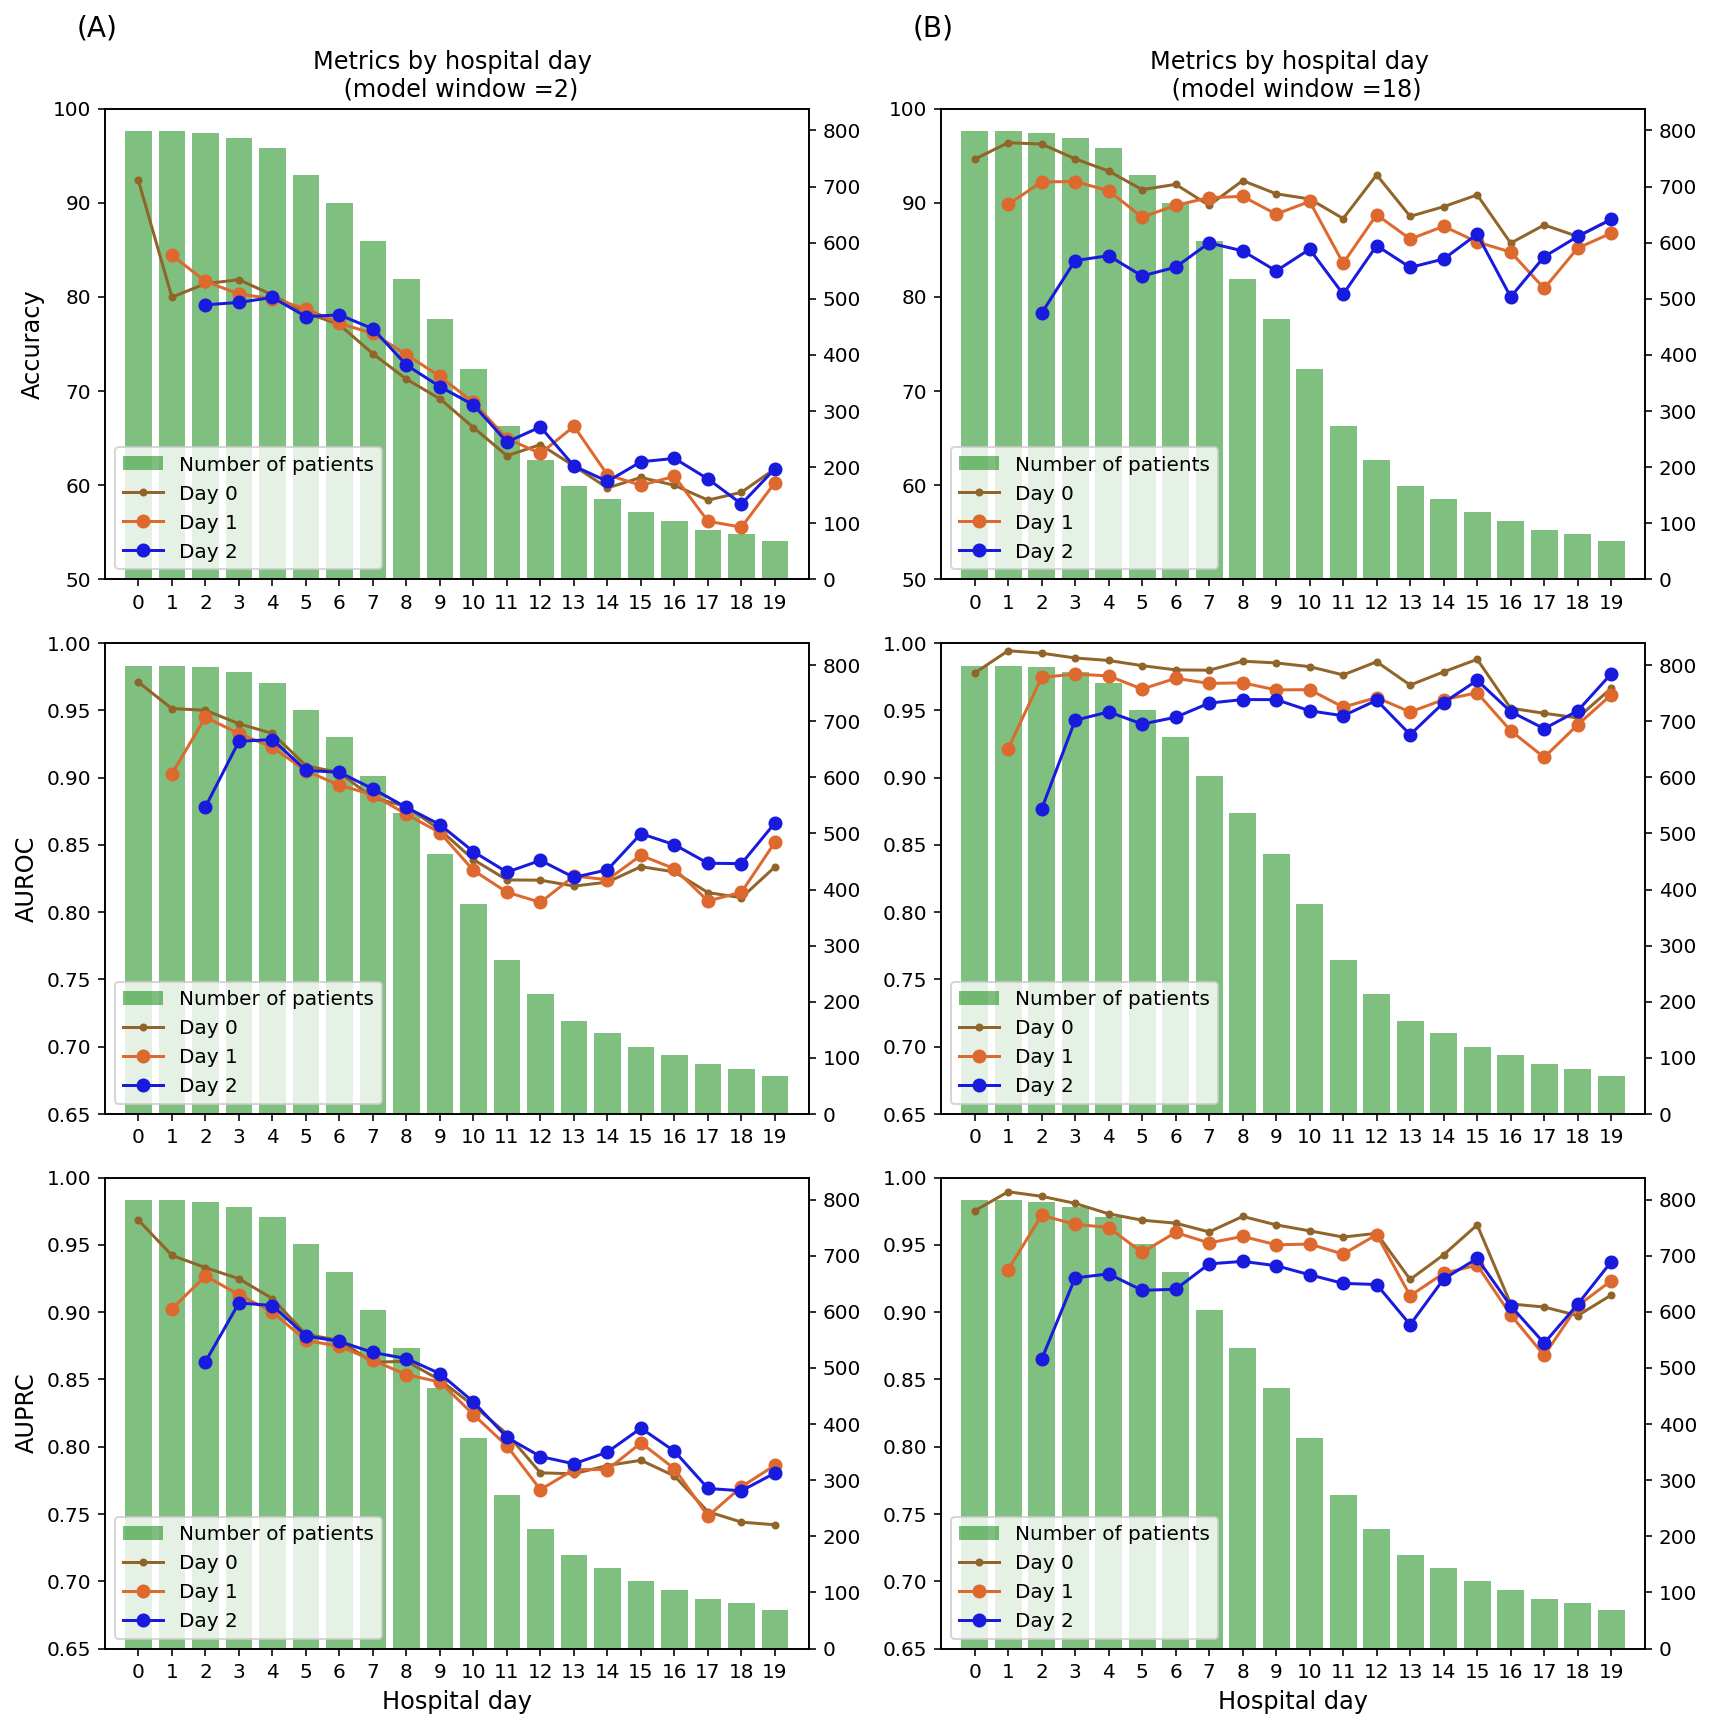

In [52]:


def plotting(daily_total, line, ax):
    ax0 = ax[0, line]
    twin0 = ax0.twinx()
    ax0.set_zorder(1)
    ax0.patch.set_visible(False)
    p01 = twin0.bar(daily_total['index'], daily_total['count'], alpha = 0.5, color = 'g', label='Number of patients')
    p02, = ax0.plot(daily_total['index'], daily_total['accuracy_x'], color = "#91652A",marker='.',  label = 'Day 0')
    p03, = ax0.plot(daily_total['index'], daily_total['accuracy_y'], color = "#DE692F",marker='o',  label = 'Day 1')
    p04, = ax0.plot(daily_total['index'], daily_total['accuracy'], color = "#181BDE", marker='o', label = 'Day 2')
    
    ax1 = ax[1, line]
    twin1 = ax1.twinx()
    ax1.set_zorder(1)
    ax1.patch.set_visible(False)
    p11 = twin1.bar(daily_total['index'], daily_total['count'], alpha = 0.5, color = 'g', label='Number of patients')
    p12, = ax1.plot(daily_total['index'], daily_total['auroc_x'], color = "#91652A", marker='.', label = 'Day 0')
    p13, = ax1.plot(daily_total['index'], daily_total['auroc_y'], color = "#DE692F",marker='o', label = 'Day 1')
    p14, = ax1.plot(daily_total['index'], daily_total['auroc'], color = "#181BDE", marker='o', label = 'Day 2')


    ax2 = ax[2, line]
    twin2 = ax2.twinx()
    ax2.set_zorder(1)
    ax2.patch.set_visible(False)
    p21 = twin2.bar(daily_total['index'], daily_total['count'], alpha = 0.5,  color = 'g',label='Number of patients')
    p22, = ax2.plot(daily_total['index'], daily_total['auprc_x'], color = "#91652A",marker='.',  label = 'Day 0')
    p23, = ax2.plot(daily_total['index'], daily_total['auprc_y'], color = "#DE692F",marker='o', label = 'Day 1')
    p24, = ax2.plot(daily_total['index'], daily_total['auprc'], color = "#181BDE", marker='o', label = 'Day 2')
    

    ax0.legend(handles=[p01, p02, p03, p04], fontsize=10, loc='lower left')
    ax1.legend(handles=[p11, p12, p13, p14], fontsize=10, loc='lower left')
    ax2.legend(handles=[p21, p22, p23, p24], fontsize=10, loc='lower left')
    
    ax0.set_xlim(-1,20)
    ax0.set_ylim(50,100)
    ax1.set_xlim(-1,20)
    ax1.set_ylim(0.65,1)
    ax2.set_xlim(-1,20)
    ax2.set_ylim(0.65,1)

    ax2.set_xlabel("Hospital day", fontsize= 12)
    
    ax0.set_xticks(range(20)) 
    ax1.set_xticks(range(20)) 
    ax2.set_xticks(range(20)) 
    if line==0:
        ax0.text(-0.04, 1.2, "(A)", fontsize= 14, ha="left", va="top", transform=ax0.transAxes)
        ax0.set_title("Metrics by hospital day \n (model window =2)")
        ax0.set_ylabel("Accuracy", fontsize= 12)
        ax1.set_ylabel("AUROC", fontsize= 12)
        ax2.set_ylabel("AUPRC", fontsize= 12)
    else:
        ax0.text(-0.04, 1.2, "(B)", fontsize= 14, ha="left", va="top", transform=ax0.transAxes)
        ax0.set_title("Metrics by hospital day \n (model window =18)")

fig, ax = plt.subplots(3,2, figsize=(12,12))
plotting(daily_total_2, 0, ax)
plotting(daily_total, 1, ax)
fig.tight_layout()


fig.savefig("./figure3.png", dpi=300)